# TestFourierTransform

## FFT of waveform

Import necessary modules

In [1]:
import numpy as np
import scipy as sc
import scipy.fft as scfft
import matplotlib.pyplot as plt
import uproot

In [2]:
from Functions import *

In [3]:
CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(23,1017)

In [4]:
print(CombinedFile.keys())
print('---------------')
#print(CombinedFile['combined'].show(name_width=60))
#print(CombinedFile['combined']['header']['trigger_time'])
TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')

['combined;5', 'combined;4', 'info;1']
---------------


In [14]:
for i in TriggerTimes:
    print(i)

1664070443.8589115
1664070450.3810034
1664070452.2100737
1664070478.370427
1664070479.1388505
1664070507.5427377
1664070555.2072358
1664070555.4769955
1664070556.3502052
1664070556.5871446
1664070582.0431688
1664070597.9469562
1664070598.3346436
1664070609.3645282
1664070625.807652
1664070651.7358599
1664070652.9284625
1664070653.0633404
1664070655.1387708
1664070656.1588814
1664070655.9208798
1664070657.0556376
1664070656.2997634
1664070657.655352
1664070656.8317978
1664070661.8231723
1664070669.0687926
1664070671.2358513
1664070678.7097125
1664070710.506033
1664070716.5505202
1664070733.4561653
1664070733.936633
1664070741.6810627
1664070746.1228235
1664070754.615439
1664070770.7177546
1664070777.891307
1664070795.9198833
1664070802.2960396
1664070825.6106918
1664070842.1072884
1664070863.844253
1664070863.0222964
1664070865.3184764
1664070867.4523087
1664070871.8513145
1664070881.5422888
1664070891.6284134
1664070911.1433692
1664070914.193201
1664070915.3075848
1664070914.7136333
16

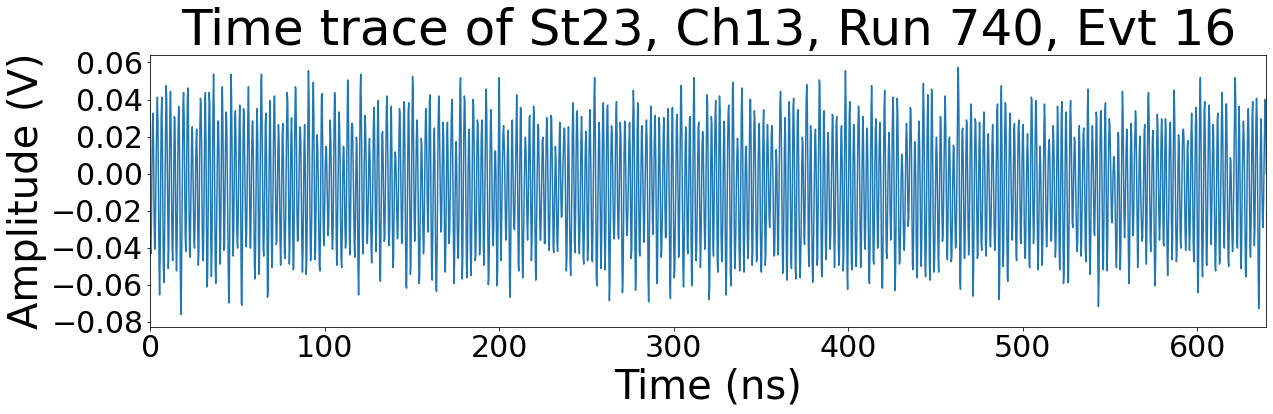

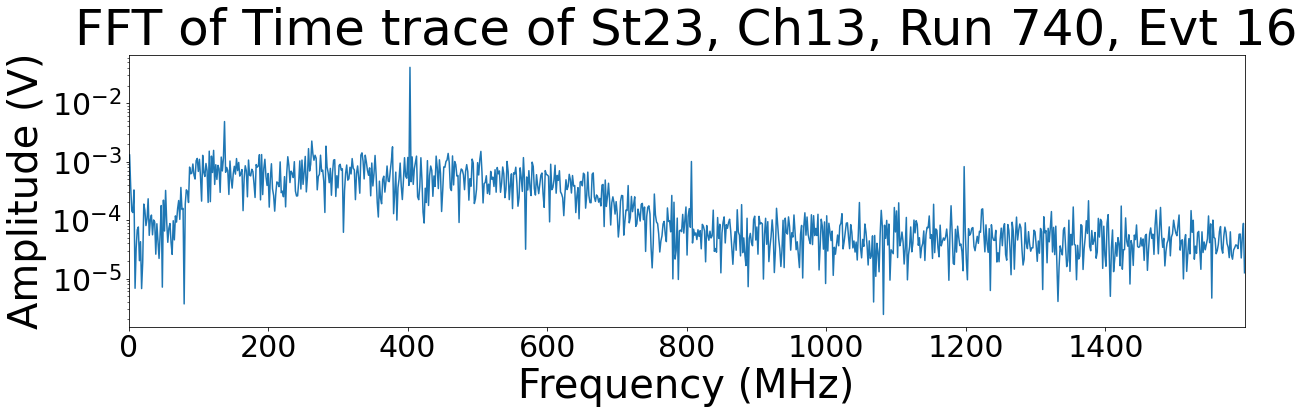

In [4]:
TimeTrace(23,13,740,16,Amplitude="V")
TimeTraceFFT(23,13,740,16,Amplitude="V",LogScale=True)

In [6]:
CmbFile=GetCombinedFile(22,712)
CmbFile['combined'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
waveforms            | mattak::Waveforms        | AsGroup(<TBranchElement 'wa...
waveforms/TObject    | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
waveforms/TObject... | uint32_t                 | AsDtype('>u4')
waveforms/TObject... | uint8_t                  | AsDtype('uint8')
waveforms/run_number | uint32_t                 | AsDtype('>u4')
waveforms/event_n... | uint32_t                 | AsDtype('>u4')
waveforms/station... | uint16_t                 | AsDtype('>u2')
waveforms/buffer_... | uint16_t                 | AsDtype('>u2')
waveforms/radiant... | int16_t[24][2048]        | AsDtype("('>i2', (24, 2048))")
header               | mattak::Header           | AsGroup(<TBranchElement 'he...
header/TObject       | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
header/TObject/fU... | uint32_t          

def FilesStRun(StNr,RunNr):
    path=Path(StNr,RunNr)
    CombinedFile=uproot.open(path+"/combined.root")
    DAQStatFile=uproot.open(path+"/daqstatus.root")
    HeadersFile=uproot.open(path+"/headers.root")
    PedestalFile=uproot.open(path+"/pedestal.root")
    return CombinedFile, DAQStatFile, HeadersFile, PedestalFile

def DailyVoltAvg(StNr,ChNr,Runs,NBins=24,ZeroAvg=True,TimeFormat="LST",Triggers=(5,5,5,5),StdCut=-1,FFTFilter=True,Lowpass=False):
    """
    Plots the Average V_RMS as a function of time of the day.
    Parameters:
    StNr,ChNr,Runs=Station number, channel number, list of runs 
    NBins=amount of bins to divide the full day in
    ZeroAvg=Boolean: if true, the timetraces will firs tbe zero averaged
    Lowpass= Boolean: if true, a butterworth lowpass filter will be applied in order to maintain only galactic noise dominated frequencies
    FFTFilter=Boolean: if true, applies a Notch filter to all frequency spectra to cut out frequencies which have shown to be potentially problematic
    TimeFormat= String: Dictates what timeformat the x-axis will be in. Options: "LST": local sidereal time, "LT": Local time & "UTC": UTC time
    Triggers=tupel of flags to dictate which triggers are allowed in the analysis. Events with different triggers are not used (0=has to be absent, 1=has to be present, anything else=both 0 and 1 can be used for analysis)
    StdCut=if larger than zero, all VRMS outliers above StdCut standard variations will be cut out of the analysis
    """
    (has_rf,has_ext,has_pps,has_soft)=Triggers
    NEvs=0
    EventRMS=np.array([]) #Array to store V_RMS value of each event
    EventTime=np.array([])#Array to store timestamp of each event
    #for (Run, EvNr) in TriggerFilterAlt(StNr, ChNr, Runs,has_rf,has_ext,has_pps,has_soft):
    for (Run,EvNr) in TriggerFilterAlt(StNr, ChNr, Runs,has_rf,has_ext,has_pps,has_soft):
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):
            NEvs+=1
        
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')        
                
            EvIndex=np.where(EventNrs==EvNr)[0][0]
            VoltageTrace=ADCtoVoltage(RadiantData[EvIndex][ChNr]) #The timetrace data in voltage
            if ZeroAvg==True:
                Vmean=np.mean(VoltageTrace)
                VoltageTrace-=Vmean
                #EventRMS=np.append(EventRMS,np.sqrt(np.mean([(V-Vmean)**2 for V in ADCtoVoltage(RadiantData[EvIndex][ChNr])])))
            if FFTFilter or Lowpass:
                sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
                TimeStep=1/sampling_rate #Time between two samples
                SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
                freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
                freq=np.fft.fftshift(freq)
                TotalFilter=np.ones(len(freq))
                if FFTFilter:
                    TotalFilter=np.multiply(TotalFilter,NotchFilters([403*10**6,120*10**6,807*10**6,1197*10**6],75,freq,sampling_rate))
                if Lowpass:
                    CritFreq=110*10**6
                    TotalFilter=np.multiply(TotalFilter,LowpassButter(CritFreq,20,freq))
                FFT=scfft.fft(VoltageTrace)
                FFT=np.fft.fftshift(FFT)
                FFT=np.array([FFT[i]*TotalFilter[i] for i in range(len(freq))])
                VoltageTrace=np.abs(scfft.ifft(FFT))
            
            EventRMS=np.append(EventRMS,np.sqrt(np.mean([V**2 for V in VoltageTrace])))
                
            if TimeFormat=="LST":
                EventTime=np.append(EventTime,LST(TriggerTimes,EvIndex))
            elif TimeFormat=="LT": #Greenland Timezone is UTC-3
                EventTime=np.append(EventTime,(UTC(TriggerTimes,EvIndex)-3)%24)
            else:
                print("Please enter a valid TimeFormat")
                return

In [ ]:
runs, evnrs=np.empty(), np.empty()

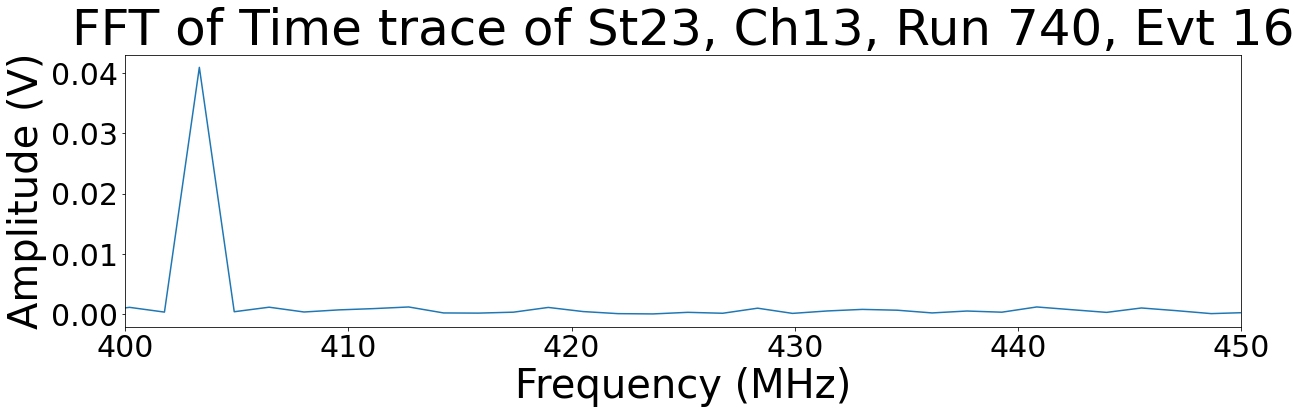

In [3]:
TimeTraceFFT(23,13,740,16,Amplitude="V")

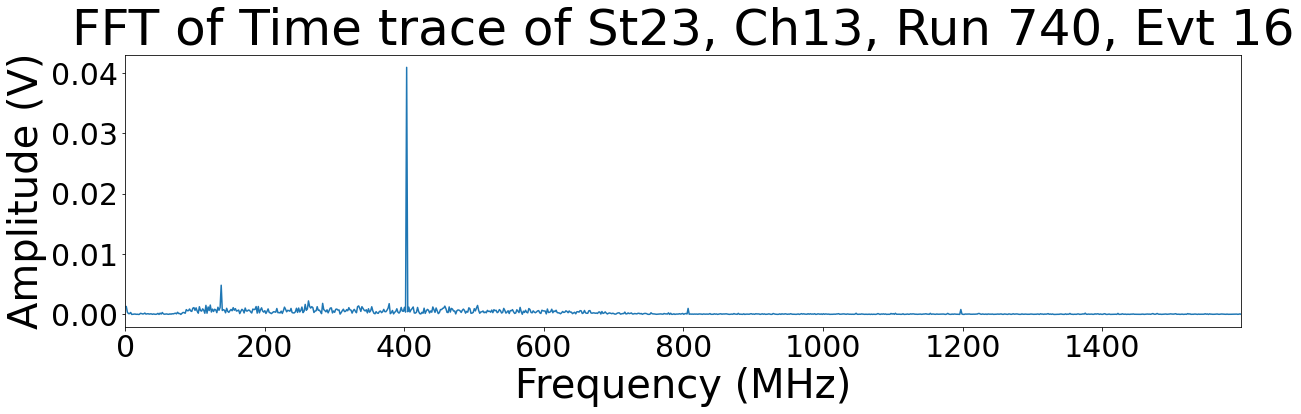

In [3]:
TimeTraceFFT(23,13,740,16,Amplitude="V")

Deze cell is om een verandering aan te brengen om te oefenen met GitHub push & pull

In [12]:
import os
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units
from NuRadioReco.framework import event,station, channel
path = os.path.dirname(detector.__file__)
path+="/RNO_G/RNO_season_2021.json"
print(path)

/storage_mnt/storage/user/jstoffels/software/jupyter_venv/lib64/python3.6/site-packages/NuRadioReco/detector/RNO_G/RNO_season_2021.json


In [16]:
name="createLPDA_100MHz_InfFirn_n1.4_InfFirn"
print(name[-8:])
print(name[:-8])

_InfFirn
createLPDA_100MHz_InfFirn_n1.4


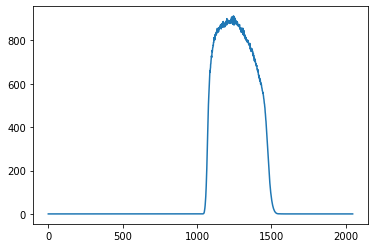

In [3]:
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units
from NuRadioReco.framework import event,station, channel
import NuRadioReco.modules.RNO_G.hardwareResponseIncorporator
import os
from datetime import datetime
import numpy as np
import scipy.fft as scfft

Date=datetime.strptime("2021-08-31","%Y-%m-%d")
detpath = os.path.dirname(detector.__file__)
detpath+="/RNO_G/RNO_season_2021.json"
    
sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
TimeStep=1/sampling_rate #Time between two samples
SamplingTimes=np.arange(0,2048*TimeStep,TimeStep)
freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
freq=np.fft.fftshift(freq)

from NuRadioReco.framework.base_trace import BaseTrace
dummy_trace = BaseTrace()
dummy_trace.set_trace(np.zeros(2048), 3.2*units.GHz)
frequencies = dummy_trace.get_frequencies()
    
GNDetector = detector.Detector(json_filename = detpath)
GNDetector.update(Date) #date in example
GNEvent=event.Event(540,11)
GNStation=station.Station(22)
GNStation.set_station_time(Date)
GNChannel=channel.Channel(13)
GNChannel.set_trace(trace=np.zeros(2048), sampling_rate=3.2 * units.GHz)
GNStation.add_channel(GNChannel) 
    

hardwareResponseIncorporator = NuRadioReco.modules.RNO_G.hardwareResponseIncorporator.hardwareResponseIncorporator()
#Filter=hardwareResponseIncorporator.get_filter(frequencies, GNStation.get_id(), GNChannel.get_id(), GNDetector, temp=293.15, sim_to_data=True, phase_only=False, mode=None, mingainlin=None)
Filter=hardwareResponseIncorporator.get_filter(freq*units.Hz, GNStation.get_id(), GNChannel.get_id(), GNDetector, temp=293.15, sim_to_data=True, phase_only=False, mode=None, mingainlin=None)
import matplotlib.pyplot as plt
plt.plot(np.abs(Filter))

In [41]:
def ReadNpArray(filename):
    with open(filename) as f:
        line = f.readline()
        NpArray=np.array([np.array([float(i) for i in line.strip(' \n').split()])])
        print(NpArray)
        while True:
            line = f.readline()
            if not line:
                break
            NpArray=np.append(NpArray,np.array([np.array([float(i) for i in line.strip(' \n').split()])]),0)
            #print(line.strip())
    return NpArray

In [3]:
import numpy as np
GalacticNoiseCurve=[np.array([]) for i in range(13)]
for i in range(100):
    Random=np.array([np.array([np.random.uniform(2,3)]) for i in range(13)])
    GalacticNoiseCurve=np.concatenate((GalacticNoiseCurve,Random),1)

print(GalacticNoiseCurve)
np.savetxt('GalacticNoiseCurveFakeResults.txt', GalacticNoiseCurve)

[[2.16757127 2.80150751 2.79383943 ... 2.22150083 2.57420966 2.27559549]
 [2.97063727 2.04711711 2.87236159 ... 2.35884828 2.70066271 2.65035399]
 [2.33220772 2.07852733 2.04441965 ... 2.08728324 2.57200806 2.014603  ]
 ...
 [2.16831938 2.81612468 2.8196949  ... 2.67110205 2.24985265 2.20094597]
 [2.8079755  2.26311992 2.89658355 ... 2.24567653 2.57574389 2.26202573]
 [2.24113254 2.6074843  2.50393665 ... 2.50982947 2.97101314 2.79164336]]


In [6]:
CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(22,541)
RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
print(EventNrs[0])

9


In [8]:
units.Hz

1e-09

In [2]:
import numpy as np
from Galactic_noise.GalaxyFunctions import StdCutRunEvtsFilter
EvIdxs=np.array([[43,65,72],[3,8,10],[52,68],[81]],dtype=object)
Runs=np.array([103,105,106,107])
#StdCutRunEvtsFilter(EvRMSIdx,Runs,EvIdxs)
StdCutRunEvtsFilter(8,Runs,EvIdxs)

(array([103, 105, 106]),
 array([list([43, 65, 72]), list([3, 8, 10]), list([52, 68])], dtype=object))

740 1024
Deleted
740 996
Deleted
740 957
Deleted
745 868
Deleted
745 900
Deleted
746 856
Deleted
746 850
Deleted
752 1310
Deleted
757 843
Deleted
758 855
Deleted
763 1060
Deleted
764 1016
Deleted
767 582
Deleted


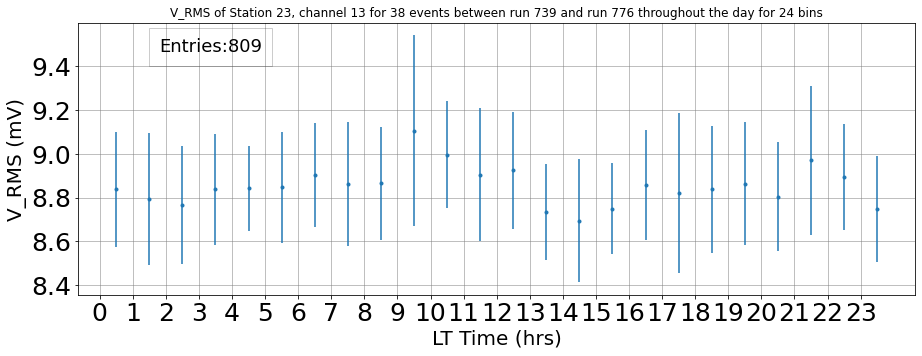

In [1]:
from Galactic_noise.GalaxyFunctions import *
RunListSt23NoComment=np.concatenate((np.arange(1,40),np.arange(147,202),np.arange(279,652),np.arange(718,872),np.arange(897,998),np.arange(1089,1135)))
RunListSt23Row=np.arange(739,777)
MidBins, VRMSAvg, FilteredRuns,FilteredEvIdxs=TransitCurve(23,13,RunListSt23Row,NBins=24,ZeroAvg=True,FFTFilter=False,TimeFormat="LT",Triggers=(0,0,0,1),StdCut=1)

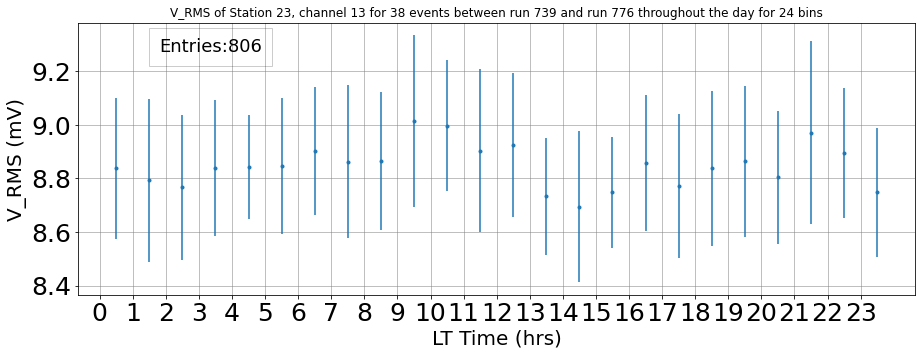

In [3]:
from Galactic_noise.GalaxyFunctions import *
RunListSt23NoComment=np.concatenate((np.arange(1,40),np.arange(147,202),np.arange(279,652),np.arange(718,872),np.arange(897,998),np.arange(1089,1135)))
RunListSt23Row=np.arange(739,777)
MidBins, VRMSAvg, FilteredRuns,FilteredEvIdxs=TransitCurve(23,13,RunListSt23Row,NBins=24,ZeroAvg=True,FFTFilter=False,TimeFormat="LT",Triggers=(0,0,0,1),StdCut=(2,3))

In [8]:
import numpy as np
Runs=np.concatenate((np.arange(1,40),np.arange(147,202),np.arange(279,652),np.arange(718,872),np.arange(897,998),np.arange(1089,1135))) #A list of all runs for Station 23 which do not have comments 
Runs=np.delete(Runs,np.where(Runs==528)[0][0])
print(Runs)

[   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39  147  148  149
  150  151  152  153  154  155  156  157  158  159  160  161  162  163
  164  165  166  167  168  169  170  171  172  173  174  175  176  177
  178  179  180  181  182  183  184  185  186  187  188  189  190  191
  192  193  194  195  196  197  198  199  200  201  279  280  281  282
  283  284  285  286  287  288  289  290  291  292  293  294  295  296
  297  298  299  300  301  302  303  304  305  306  307  308  309  310
  311  312  313  314  315  316  317  318  319  320  321  322  323  324
  325  326  327  328  329  330  331  332  333  334  335  336  337  338
  339  340  341  342  343  344  345  346  347  348  349  350  351  352
  353  354  355  356  357  358  359  360  361  362  363  364  365  366
  367  368  369  370  371  372  373  374  375  376  377  378  379  380
  381 

In [7]:
from Functions import *
CombinedFile=GetCombinedFile(23,12)
RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np') 
#EvIdx=np.where(EventNrs==EvNr)[0][0]
for i in TriggerTimes:
    print(i)

1656446973.2262888
1656446974.6366
1656446975.0667806
1656446976.1420398
1656446977.1600769
1656446983.4810243
1656446988.9752512
1656447002.5665746
1656447009.0960975
1656447011.2868898
1656447012.2293663
1656447017.640527
1656447024.1555734
1656447035.4051497
1656447037.0620563
1656447036.170217
1656447037.568203
1656447038.198995
1656447038.9002802
1656447040.2703662
1656447042.6362593
1656447050.499332
1656447051.7147171
1656447051.7820513
1656447052.6699147
1656447053.2057862
1656447061.8311994
1656447071.1104631
1656447078.746097
1656447082.9059603
1656447086.422713
1656447094.2105196
1656447095.3143222
1656447095.479539
1656447099.056056
1656447101.5960877
1656447104.360206
1656447110.6033926
1656447112.9314284
1656447113.250052
1656447113.6731997
1656447114.6570902
1656447117.266904
1656447118.531392
1656447130.7014153
1656447150.040793
1656447150.252887
1656447164.1079311
1656447165.2224991
1656447166.9848855
1656447167.8912187
1656447172.337383
1656447176.7914667
1656447176.9

In [1]:
from Functions import *
CombinedFile=GetCombinedFile(23,492)
RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np') 
#EvIdx=np.where(EventNrs==EvNr)[0][0]
for i in TriggerTimes:
    print(i)

1660356054.9194338
1660356127.464995
1660356148.4845285
1660356160.0121017
1660356323.5546694
1660356367.5920985
1660356529.477189
1660356668.2772627
1660356776.7729332
1660356778.5883021
1660356813.3799384
1660356813.5136023
1660356847.4328296
1660356850.433203
1660356870.5265615
1660356908.726892
1660356928.5883548
1660357050.4297717
1660357131.3149743
1660357342.3337498
1660357378.5883353
1660357518.4080725
1660357548.726344
1660357792.0396454
1660357809.1350987
1660357818.969493
1660357826.238365
1660358178.5882096
1660358197.8846033
1660358211.1841438
1660358263.0814953
1660358304.6800978
1660358329.694496
1660358374.4655077
1660358408.588289
1660358435.1463277
1660358515.5068767
1660358588.5882394
1660358604.3760958
1660358633.73848
1660358644.1889992
1660358689.9294424
1660358739.548476
1660358956.9290805
1660358979.2608001
1660359043.7062573
1660359048.6191297
1660359168.1270368
1660359263.9881513
1660359295.9777768
1660359346.2539191
1660359355.5569575
1660359414.3079212
16603

In [6]:
from Functions import *
CombinedFile=GetCombinedFile(23,13)
RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np') 
#EvIdx=np.where(EventNrs==EvNr)[0][0]
for i in TriggerTimes:
    print(i)

1656454199.6742878
1656454201.635476
1656454208.6723316
1656454211.9823027
1656454223.1342838
1656454225.0547466
1656454226.0058055
1656454227.6625602
1656454232.9316258
1656454236.038337
1656454238.8916643
1656454238.9466841
1656454239.3255765
1656454240.7050688
1656454253.0287158
1656454270.588828
1656454269.7108605
1656454275.3107615
1656454280.2493086
1656454284.7888992
1656454285.7620914
1656454288.914658
1656454293.8842385
1656454295.1934433
1656454298.745216
1656454304.9816794
1656454307.5739741
1656454316.2212455
1656454317.472945
1656454320.2802
1656454324.1153839
1656454326.7232935
1656454328.8920503
1656454334.1849024
1656454334.9850557
1656454339.690305
1656454347.3972352
1656454349.7960522
1656454357.5995026
1656454360.725662
1656454369.2443466
1656454369.97611
1656454370.8522336
1656454371.9911056
1656454371.070088
1656454372.6449697
1656454374.8782012
1656454380.899211
1656454382.10108
1656454388.8496754
1656454389.5961516
1656454394.3323529
1656454395.165338
1656454399.

In [1]:
from Functions import *
CombinedFile=GetCombinedFile(23,651)
RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np') 
#EvIdx=np.where(EventNrs==EvNr)[0][0]
for i in TriggerTimes:
    print(i)

1661494706.3012593
1661494798.0328047
1661494827.5863218
1661494831.7203033
1661494833.9649544
1661494869.51516
1661495007.586324
1661495232.4768767
1661495273.0969613
1661495347.6205227
1661495487.3413253
1661495537.6077604
1661495760.0859785
1661495820.0753758
1661495887.8922102
1661495903.4733531
1661495949.1962607
1661495972.1030655
1661495975.0756714
inf
inf
1661496119.0552206
1661496128.8476186
1661496147.0501912
1661496177.9210842
inf
inf
inf
inf
inf
1661496579.049619
inf
inf
1661496795.2381067
inf
inf
inf
1661496993.4121616
1661497216.1679595
1661497287.1056213
inf
1661497334.7597396
inf
1661497472.444045
inf
inf
1661497623.074681
inf
1661497737.7642267
1661497796.1072423
inf
inf
1661497878.8908331
1661497927.0616453
1661497957.2053077
inf
inf
1661498200.0906434
1661498523.1408298
1661498567.0882838
1661498645.245962
inf
1661498755.089256
1661498828.0477226
inf
1661498931.1013067
inf
inf
1661499119.0617764
1661499144.953654
1661499232.0844374
1661499272.0939007
inf
1661499524.2

In [3]:
from Functions import *
CombinedFile=GetCombinedFile(23,847)
RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np') 
#EvIdx=np.where(EventNrs==EvNr)[0][0]
for i in TriggerTimes:
    print(i,str(np.isinf(i)))

1662885465.7242727 False
1662885472.6252334 False
1662885482.5891132 False
1662885552.7049046 False
1662885579.1414618 False
1662885607.1122282 False
1662885650.4944909 False
1662885692.6258302 False
1662885702.2703385 False
1662885732.5890384 False
1662885759.9761508 False
1662885851.4045448 False
1662885857.5023372 False
1662885909.9386232 False
1662886046.481031 False
1662886072.5891337 False
1662886091.7213538 False
1662886152.6296372 False
1662886351.2882717 False
1662886356.1450114 False
1662886485.1196182 False
1662886578.4940467 False
1662886620.6913898 False
1662886642.589018 False
1662886668.3983092 False
1662886677.7678182 False
1662886682.6261644 False
1662886814.4859624 False
1662886853.5012548 False
1662887022.5896385 False
1662887045.484573 False
1662887262.59704 False
1662887329.1850374 False
1662887372.5905879 False
1662887375.4486046 False
1662887410.7441168 False
1662887452.5906336 False
1662887458.638256 False
1662887578.4636528 False
1662887626.3495233 False
166288

In [14]:
import numpy as np
T=np.array([np.array([0.0020891941414985173, 0.0017914188862410943,
       0.0020613387407753926, 0.001975804570093308, 0.001972247513239433,
       0.0018440045631841686, 0.0021496673719418042, 0.002018037792507172,
       0.0017317633452657382, 0.0024167560663677866,
       0.0024461441186380273, 0.0020652280948440637, 0.001907334997537327,
       0.0021156843956293154, 0.0018996707118057435, 0.002022140556962598,
       0.001918005420293477, 0.0023818152071459586, 0.0021357618254446006,
       0.0020735104183345877, 0.0018126806622479473, 0.002051024657710302,
       0.001955639176989726], dtype=object),
 np.array([0.0019864147597009516, 0.001973042168085477, 0.0018818740167198791,
       0.0018973903426097811, 0.0023075876192388224,
       0.0022344290798406202, 0.002177734148739264, 0.0019441616397927134,
       0.002376654201333289, 0.0019457773515057042, 0.0022429022723613437,
       0.0019209574642642265, 0.002201684199127179, 0.0020707702199564597,
       0.0022424220219925298, 0.001981541715167219, 0.0022059528041061456,
       0.0021504348188711156, 0.0019870961710372554, 0.002073075703831438,
       0.0020011247527258872, 0.0017665439118423431,
       0.0016764081358242987], dtype=object),
 np.array([0.002438104325360833, 0.002291112376379191, 0.0022851815949191463,
       0.001678005155435095, 0.0019317588047347099, 0.0018056423575272614,
       0.0021441218776167147, 0.0020390068966770324, 0.002068873615440474,
       0.0021563350952259162, 0.0019983359062736273,
       0.0019245795752776478, 0.0024174992945982326, 0.002058018611471724,
       0.0021540530624860714, 0.001754343987379044, 0.0018944316033095295,
       0.002383216477736478, 0.0022564608381709177, 0.0021967086262306658,
       0.0020363523046714755, 0.002113545388005983, 0.0019755067577505534,
       0.0019872797844296608, 0.001977850769502632, 0.002071457778154041,
       0.002088139853472973, 0.0018873228527565616, 0.0019890842512830663,
       0.0022300102659310998, 0.002035856344900221, 0.0018262554791189409,
       0.0018770606298178635], dtype=object),
 np.array([0.002123632400770589, 0.001925678366501021, 0.0020905037968455874,
       0.0023986728902956203, 0.002099152390273731, 0.0022295551528807404,
       0.002250265603245463, 0.0019332066528950035, 0.002304378956837853,
       0.002089428499627547, 0.0018334624279715953, 0.0021849006855096504,
       0.0018912936603678768, 0.002177705479820375, 0.001967921898475331,
       0.0019812578902426384, 0.002066658434045508, 0.002382877509964969,
       0.0021824344390509874, 0.0023655605159043627, 0.002024237535656909,
       0.0021144155819824966, 0.0018659986961886957,
       0.0021808059985779127], dtype=object),
 np.array([0.0020069353110574936, 0.0018450468416983503,
       0.0020645946214852442, 0.0021031969675022032,
       0.0024141640024065688, 0.0020998281991890526, 0.001970743185303739,
       0.002158274684590732, 0.0018899203349478748, 0.002069360937156463,
       0.002454806881298385, 0.0020818985969377423, 0.002166944119385949,
       0.0017950214076957135, 0.00240081850928446, 0.0020413540337900537],
      dtype=object),
 np.array([0.0018588649694621158, 0.0017806979443141246,
       0.0016384498720473613, 0.002582291210838505, 0.001981532929051329,
       0.0018720546411823012, 0.0021786564445047747, 0.001835235712161838,
       0.0022225760178145953, 0.0018782176780841487,
       0.0017485469602716208, 0.0018877303140761692,
       0.0016645644541381688, 0.0024104277831153136,
       0.0020461724807403336, 0.001987685907185, 0.0019599530184396577,
       0.0020341568272576995, 0.002015172956244508, 0.002104837274191916,
       0.0021674719944972565, 0.0019723656535894467, 0.002365345661072971,
       0.0023444622151278655, 0.0024030623986151345,
       0.0020044825267440847, 0.0017886872210187929, 0.002028604495927271,
       0.002037790174196946, 0.0019494510292720065, 0.002088271873002644,
       0.002106004526412754], dtype=object),
 np.array([0.0023667661481354047, 0.001968896078110684, 0.0024239943102210833,
       0.001778045306870804, 0.0020876613955513354, 0.001790517754847686,
       0.0021759941971808295, 0.0022420063260506864,
       0.0020327859387212974, 0.0016869365964232658,
       0.0019502890703903682, 0.002001592261179246, 0.002292773834462808,
       0.002176382192595082, 0.0021701509678580377, 0.0020101595947279653,
       0.0018051877133775371, 0.002329412519131348, 0.0019780720318958067,
       0.0019560879131851555, 0.0020474761658611945], dtype=object),
 np.array([0.0019241111222511192, 0.0019555265926972883,
       0.0022464820283686314, 0.0024428691371720414, 0.00184894571004941,
       0.002396407528376951, 0.0020361812876266865, 0.0020426928921493366,
       0.0022092278982060185, 0.0022645084245352335,
       0.0018538596304303278, 0.001966360032876248, 0.001972551019129117,
       0.0016996227683569586, 0.0020736012534664353, 0.00184641855232955,
       0.001747565102839617, 0.0018190076187390998, 0.0020361742184559287,
       0.0021795345063955287, 0.0018676215722922896], dtype=object),
 np.array([0.0018833539459547006, 0.0021770693490924396, 0.001914278694267139,
       0.0020415351452817395, 0.0021254781225659727, 0.001847422258771357,
       0.0020989428224835924, 0.0019482034066748786,
       0.0020453647171377173, 0.001831246379531855, 0.0019323326547583538,
       0.0023732040844737564, 0.002129393088728803, 0.002023541025430795,
       0.0020189227527734168, 0.0021904946229476113,
       0.0023517562076086226, 0.002028070342527069, 0.0019263519439194506,
       0.0022251173222081733, 0.0019705082260576016,
       0.0022572710560002456, 0.001721462183983377, 0.002156373356282573,
       0.0021070458300660524, 0.0018699807631914387, 0.00195934530280336,
       0.0021096832763107245, 0.0017954105357329243,
       0.0019533876943384656, 0.0020266211778230433,
       0.0017137037439394211, 0.0018026949836948702,
       0.0017721460293129772], dtype=object),
 np.array([0.0018922133132110483, 0.0018497818346242677,
       0.0018785363896371258, 0.002362103872868006, 0.0018328738920598273,
       0.0017602169569562772, 0.0020074429178222053,
       0.0020107991836342187, 0.002413385375508127, 0.0020984264304963252,
       0.0019189992296612087, 0.002025690338822147, 0.0019180034680619852,
       0.0019903876163163644, 0.002038855766651141, 0.0016777641161439879,
       0.002186633434364319, 0.0021367389131495902, 0.001981695390959696,
       0.0019483498898235558, 0.0019354629827727158, 0.002094666376124628,
       0.002001967452318087, 0.001990899400054876, 0.002003120397426539],
      dtype=object),
 np.array([0.0023978321342490796, 0.0021044774758030307,
       0.0018223219835310966, 0.0020954818535318985,
       0.0019529377913202121, 0.0017613718039178482, 0.001905623545146816,
       0.002022813137853901, 0.00191872361307661, 0.0018058676625910522,
       0.0018623679757211868, 0.001888034104996447, 0.001948185565910334,
       0.0023710616448091885, 0.0019529144357094714,
       0.0019524393053322886, 0.0020478020736840125, 0.001667130897076438,
       0.001972959455761497, 0.002083424411381444, 0.00199344124684075],
      dtype=object),
 np.array([0.00204500790639821, 0.002025473363657198, 0.0019210394344805807,
       0.0023624898173587082, 0.0022160145332001412,
       0.0016499482546227851, 0.0019616404253834504, 0.001806857167696871,
       0.0019736456990399674, 0.0021028264759494026,
       0.0021476775624137954, 0.0019912400414330775, 0.001733442596968738,
       0.0018964930390157504, 0.0021374573981731383, 0.002041000457292549,
       0.0020954821955256166, 0.0022424820448273676, 0.002209371672079307],
      dtype=object),
 np.array([0.0017799744631333673, 0.0019109229542734428,
       0.0019880855338013275, 0.0019306920414714885,
       0.0019990463259675173, 0.0020337214027781, 0.0021286043434284854,
       0.0019335904396353938, 0.0019341820365763116, 0.002019331348773826,
       0.0021656526199084207, 0.001975134130568641, 0.0019927851925633775,
       0.0019294077279712772, 0.001951462132328193, 0.00233799828198332,
       0.0017925327289570107, 0.0020079163933012212,
       0.0020316258031825127, 0.0017038492373121707,
       0.0020712660909723846, 0.0018617572125901225,
       0.0019565424853978013, 0.002096900891114967, 0.0019319872477522877,
       0.0018024388792654887, 0.0017992698417052698,
       0.0021386078968669716, 0.0016944628488582349,
       0.0023196054596769334], dtype=object),
 np.array([0.0020767155413328677, 0.002057189033276525, 0.0020315582549750143,
       0.002186025950177724, 0.0017772938862381253, 0.0019247964702664838,
       0.0017660727672746553, 0.0019488020763397975, 0.001840199370833994,
       0.0020178407168478948, 0.002197276148401271, 0.002114345196167023,
       0.001911963485607674, 0.0020222397320301855, 0.002089907072787107,
       0.0018976023079469437, 0.0020705105457169957, 0.00191509297530307,
       0.0017442763481264477, 0.0020152083726555046, 0.001979597735420079,
       0.0023378286888653256, 0.0019753846286626043,
       0.0018041491913840272, 0.002104641773286795, 0.0018725519692857264,
       0.0020181558687255743, 0.0018357317448210201,
       0.0021679242993116023, 0.0021538046689985454,
       0.0019586224665607403], dtype=object),
 np.array([0.0018871432675371643, 0.001972388093331144, 0.001961791814945157,
       0.002392448649671514, 0.0019299871623566925, 0.0022017671318858905,
       0.002202755484273583, 0.0019306908680926012, 0.0018065034414147944,
       0.0025131134056426705, 0.0021202317640015202,
       0.0025749174415124402, 0.0018251857868032953, 0.002032210824801962,
       0.0021174207165719438, 0.002107933348583471, 0.002244492473573949,
       0.002172775235408923, 0.0021186395514101917, 0.0021046001707162865,
       0.0021570273554625337, 0.0021829733391461117,
       0.0020053630343170475, 0.0020402265320361656, 0.001626020590508849,
       0.0021342414190275998, 0.0019454158658715017,
       0.0019990047425462944, 0.0023360466135299456,
       0.0019371398219713528, 0.0021876608644009346,
       0.0020924320140444036, 0.0017349013608606106,
       0.0018215702549499756, 0.0018210929660524926,
       0.0021566622310700257, 0.0022011575566393497,
       0.0020402615927149577, 0.0016776682731468489], dtype=object),
 np.array([0.0023705249900033924, 0.0022185309712744435,
       0.0020106550274695298, 0.0018246790321399774, 0.002076921893783723,
       0.0021398430062663605, 0.001957920936280117, 0.0021100839951024544,
       0.0021527433038655117, 0.002240715909157301, 0.0019955818491808955,
       0.001984599357036241, 0.002146422528885664, 0.0018615002018621835,
       0.0016496133073992149, 0.0021177474023065484,
       0.0019450862427113295, 0.0021159557837132368,
       0.0016582224216273125, 0.0021010116533166077, 0.002179782683391177,
       0.0019281045041831207, 0.0019638094696961795, 0.00232944536646419,
       0.0020816215616681713, 0.0022857402384692206,
       0.0017893811058597453, 0.002031799261390072, 0.0020342081895770333,
       0.0021899518454831907, 0.0021728991755538144,
       0.0022747191691250544, 0.0023041592817233504,
       0.0016578804681074903, 0.0018167228535405963,
       0.0023601842662828217, 0.002068204028629667, 0.0020476813024757363,
       0.002190934452302592, 0.0022637491740943776, 0.002074048842204496,
       0.0022004094910737094, 0.0021478572780862224,
       0.0019921746008811376], dtype=object),
 np.array([0.001849552194176898, 0.0018654116608611705, 0.001881230000486074,
       0.002234292392366123, 0.001990329820397155, 0.0019950649519800343,
       0.0022754152381289855, 0.002229697747636567, 0.002268488580421942,
       0.0017692347378802896, 0.0018140360293989655,
       0.0018887574969381218, 0.0021798886341143683, 0.002325680477860026,
       0.0018191633435956681, 0.001739129941061362, 0.0018112673341529597,
       0.002038904252266588, 0.00186759097810742, 0.002018312138909833,
       0.002386962578106226, 0.0019437525081683294, 0.002012571792852912,
       0.0018472376714023934, 0.0019847610393675373,
       0.0022449416415738603, 0.001975053620905246, 0.001903975153810927,
       0.0019495753578313393, 0.0023372671132422585, 0.001973091261807901,
       0.0022027400425536432, 0.0019335964356541402, 0.00230052483226887],
      dtype=object),
 np.array([0.0022172734173408547, 0.0022833305780056755, 0.001995777253018648,
       0.0020596647083386843, 0.0021882705682365724,
       0.0023273783204928837, 0.0020904035379858896,
       0.0020086820463252188, 0.002150356580746055, 0.0023527408037765864,
       0.002019517913831136, 0.002156076864600955, 0.0020846528931988194,
       0.0024166560600663105, 0.0019143991898845634,
       0.0021285514300836985, 0.0018628679567603366, 0.002112021231322465,
       0.002032188248737107, 0.002053095504878048, 0.002357337050092299,
       0.0023336478686142186, 0.0022184274334199464,
       0.0022324840130503927, 0.0017570093659547766, 0.002295732197622692,
       0.0019240072873629671, 0.002094092197890178, 0.002274488252097739,
       0.0020334720745557406, 0.0023471145130218958, 0.002249950857101992,
       0.0023846422240280077, 0.0019163268858976776, 0.001707342487456957,
       0.002090852963503591, 0.0021738668428988627, 0.002215571592573806,
       0.002106301427035808, 0.0023268973346704963], dtype=object),
 np.array([0.0019758019369937626, 0.002020343329879645, 0.002018183599373141,
       0.0020333673992645276, 0.0019863160693451135,
       0.0022646080668014797, 0.0023406415409008524,
       0.0022072979756185417, 0.002287815407085215, 0.00221319898442283,
       0.002463286822980603, 0.002070554478258185, 0.0023878857720900323,
       0.0021168206508419517, 0.002072698185666374, 0.002198918429110394,
       0.002408702908403498, 0.0018864045667685294, 0.002223098265204744,
       0.002291829643037817, 0.0020354696644873916, 0.0024332659581386504,
       0.0020137691149014385, 0.0021771215204687173, 0.001991784533108826,
       0.0023430176318970674, 0.002151559723645603, 0.0020458778431784726,
       0.002118021359233009, 0.0020599940784096983, 0.0019826566343416835,
       0.0016647528677444855, 0.0018798968708961417,
       0.0021342216753986783, 0.0020837557597819067, 0.002251468378290344,
       0.0019419392540031622, 0.001784061804218663, 0.002352605056910815,
       0.002279152552260192, 0.002382213984895797, 0.0022043272694107514,
       0.0017554019835720439], dtype=object),
 np.array([0.0024283973925088857, 0.002112928471683726, 0.002484486885175464,
       0.0020433468304974414, 0.002030098647894967, 0.002054293063231954,
       0.0021856749895887272, 0.0016429786243480349, 0.002104273753630185,
       0.0018226934594709552, 0.002321722979896715, 0.0022514839449233283,
       0.002129110935077048, 0.0020846545929414685, 0.0021808309146492204,
       0.0018579004002401084, 0.0021442409410170277,
       0.0021200326291344377, 0.0020772119255744784, 0.00212898939424857,
       0.0021955121303147457, 0.0020438119345398747,
       0.0020970194922105994, 0.0021710951542444003,
       0.0019426211319368979, 0.002028361598290366, 0.0022493885472436607,
       0.002208149624467137, 0.0022064886439925315, 0.0019847263801059853,
       0.0022000163162252183, 0.0022919366286775224, 0.002074911425173398,
       0.0019959429372910596], dtype=object),
 np.array([0.0022483062108310634, 0.0022638686123968, 0.0022235803497840417,
       0.0018951455474146605, 0.002350279616416358, 0.0019821802687438744,
       0.0021203532447977964, 0.0019848941334464224, 0.001583950068105064,
       0.00224105590588975, 0.0020485481627102726, 0.0021912533797688815,
       0.0018599116872794327, 0.0019102729749926797,
       0.0021863914058858477, 0.0023154039913032857, 0.002297895921183291,
       0.00209795470085671, 0.0019834505572020955, 0.0019266083435718693,
       0.002203483430188852, 0.0017720767959704278, 0.002335618265101647,
       0.0022519709245529514, 0.002320546684404146, 0.0021422947461322774,
       0.002534545823896981, 0.0020418977347066705, 0.0022080071535602484,
       0.0022622465242002504, 0.001941888326138086], dtype=object),
 np.array([0.0019027911063650346, 0.0021675425731404727,
       0.0020835425925080403, 0.0018370086414149847,
       0.0017459961556405535, 0.001951028296664311, 0.0020521183128277506,
       0.0016973288848706367, 0.002132707598058791, 0.001972368768697789,
       0.001773198358321888, 0.0019924460997656286, 0.002292929905565737,
       0.0022932174287679306, 0.001954804678641525, 0.00193962599547935,
       0.002275551988515704, 0.0019431523111557698, 0.0018883306494059948,
       0.001953512098149148, 0.0023293967332106962, 0.002118474336561703,
       0.002066398827020058, 0.002377965126539751, 0.0021208090348569077,
       0.00237929379021543, 0.002172607388736201, 0.0023648724245597663],
      dtype=object),
 np.array([0.0022860008422222124, 0.002543754093101576, 0.0018877783252984502,
       0.0021678921474126644, 0.0020918577620614824, 0.001944490326753986,
       0.0020244923693497506, 0.001985830977876822, 0.0018927279821912449,
       0.00236174978552913, 0.002216355296975205, 0.002021699127458164,
       0.002121719745241663, 0.002239908328219895, 0.0017638502350049694,
       0.001797506194966559, 0.0022165558345622637, 0.0021226752598540303,
       0.0020416223675652806, 0.001951390301136348, 0.0022843678029013047,
       0.0017170179487323287], dtype=object),
 np.array([0.001953708989911227, 0.002227776832234342, 0.002211296456188795,
       0.0023427608327762466, 0.0018639315675562536,
       0.0020284757096528435, 0.0025607015501295147,
       0.0019094338568392162, 0.0022827048011970566,
       0.0023491843976915293, 0.002278580694088085, 0.0020701073342058334,
       0.001962520389526294, 0.0022633082738282373, 0.0024093831233721395,
       0.0020665996224370764, 0.001727087411661027, 0.001982161946730986,
       0.0021630192861008275, 0.0020459163795278766,
       0.0021818594519991243, 0.0024263866940998097, 0.00202260480085945,
       0.0021275276125916594], dtype=object)],dtype=object)


#np.savetxt('Test.txt', T)
np.save("test",T)
U=np.load("test.npy",allow_pickle=True)
print(T==U)

False


/storage_mnt/storage/user/jstoffels/software/jupyter_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:279: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [20]:
D1=np.load("FilteredEvIdxs_1835107-0.npy",allow_pickle=True)
D2=np.load("FilteredRuns_1835107-0.npy",allow_pickle=True)
D3=np.load("GroupedVRMS_1835107-0.npy",allow_pickle=True)
D4=np.load("MidBins_1835107-0.npy",allow_pickle=True)

In [24]:
print(D4)

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5]


In [ ]:
from Galactic_noise.GalaxyFunctions import *
RunListSt23NoComment=np.concatenate((np.arange(1,40),np.arange(147,202),np.arange(279,652),np.arange(718,872),np.arange(897,998),np.arange(1089,1135)))
RunListSt23Row=np.arange(739,777)
RunListSt23NoComment=np.delete(RunListSt23NoComment,np.where(RunListSt23NoComment==528)[0][0])
TransitCurve(23,16,RunListSt23NoComment,NBins=24,ZeroAvg=True,TimeFormat="LST",Triggers=(0,0,0,1),StdCut=1,Lowpass=True)

Inf timestamp at: Run12, EvNr28595
Inf timestamp at: Run12, EvNr29468
Inf timestamp at: Run12, EvNr33452


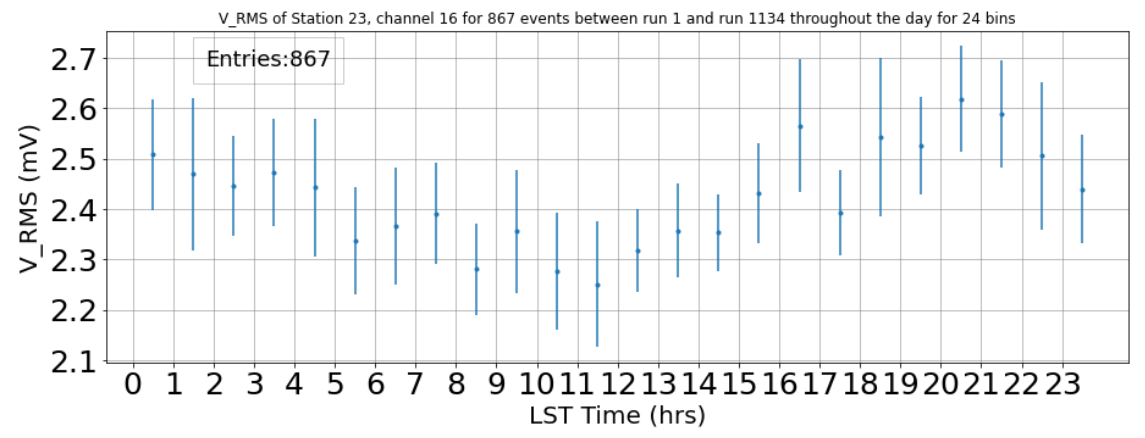